In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath("../src"))

In [2]:
from region_extractor import RegionWrapper, MinecraftRegionExtractor
import pandas as pd
from pympler import asizeof


extractor = MinecraftRegionExtractor("/home/kyre/repos/minecraft-world-generator/data/RUNETALE Converged Realms")
regions = extractor.get_regions()
total_memory = sum(asizeof.asizeof(r) for r in regions)
print(f"Total memory for all regions: {total_memory / (1024**2):.2f} MB")


Loading regions: 100%|██████████| 363/363 [00:00<00:00, 1782.39it/s]

Total memory for all regions: 1265.26 MB


In [3]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from numpy import average

rows = []

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(region.get_inhabited_times): region for region in regions}
    for future in as_completed(futures):
        region = futures[future]
        try:
            inhabited_times = future.result()
            rows.append({
                "Region_X": region.x,
                "Region_Z": region.z,
                "Inhabited_Time": average(inhabited_times)
            })
        except Exception as e:
            print(f"Region ({region.x}, {region.z}) generated an exception: {e}")

df = pd.DataFrame(rows)
df["Inhabited_Time"] /= 20  # Convert ticks to seconds
df["Inhabited_Time"] /= 3600  # Convert seconds to hours

In [4]:
df.describe()

,Region_X,Region_Z,Inhabited_Time
count,363.000000,363.000000,363.000000
mean,1.498623,-3.977961,44.925352
std,23.775118,4.845635,127.433193
min,-16.000000,-15.000000,0.000000
25%,-8.000000,-8.000000,0.000906
50%,-3.000000,-4.000000,0.210969
75%,0.000000,0.000000,21.117856
max,99.000000,7.000000,933.552797


<Axes: xlabel='Inhabited_Time', ylabel='Count'>

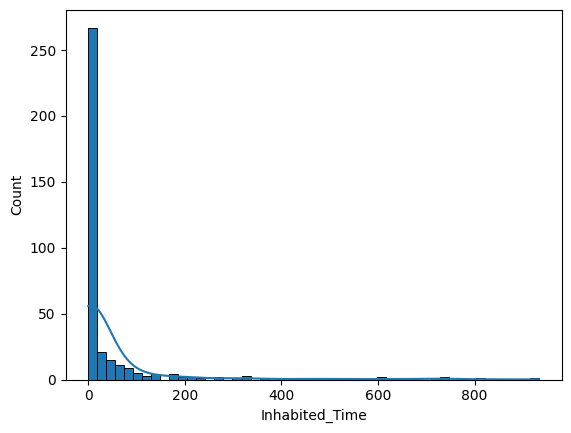

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df["Inhabited_Time"], bins=50)
sns.histplot(df["Inhabited_Time"], bins=50, kde=True)


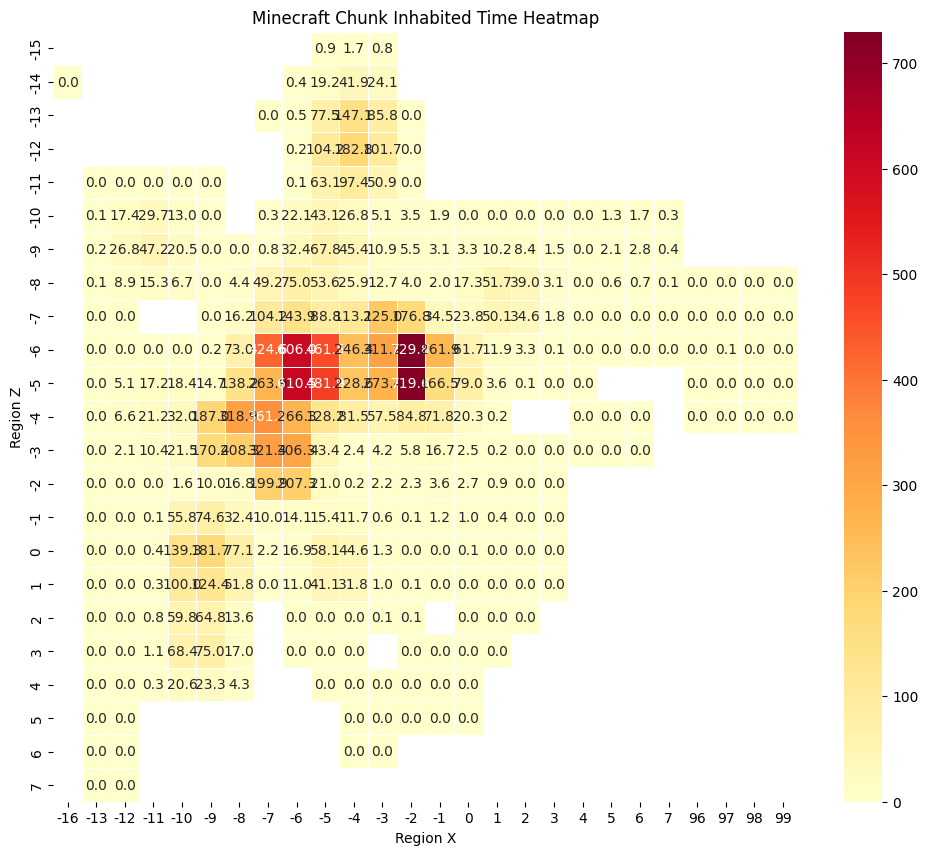

In [8]:
heatmap_data = df.pivot_table(
    index='Region_Z',
    columns='Region_X',
    values='Inhabited_Time',
    aggfunc='mean'  # or 'sum', depending on what you want
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data, 
    cmap="YlOrRd",   # yellow-orange-red color map
    linewidths=0.5,  # optional grid lines
    annot=True,      # optional: shows numbers
    fmt=".1f"
)
plt.title("Minecraft Chunk Inhabited Time Heatmap")
plt.xlabel("Region X")
plt.ylabel("Region Z")
plt.show()
